# LDA on public data, 5 classes

This notebook contains code to perform LDA and analysis on a dataset of archeology

** **
#### Step 1: Loading Data <a class="anchor\" id="load_data"></a>
** **

In [1]:
import pandas as pd

path = "../../all_dataset.csv"
df = pd.read_csv(path)

# Print head
df.head()

,filename,text
0,PlanActionDD_MSSS_2016,\nPLAN D’ACTION DE\nDÉVELOPPEMENT\nDURABLE-202...
1,PlanDD_Rio tinto2019,\nRapport de développement durable 2019\nGroup...
2,Rapport_CREDD_2019,\nPrésentation CREDD\nRAPPORT ANNUEL-2020\nSOM...
3,Plan_QuébecEnvironnement_2020,\nGAGNANT\nPOUR LE QUÉBEC.\nGAGNANT\nPOUR LA P...
4,SADR_MRCDDR_2015,\nSchéma d’aménagementet de développement révi...


** **
#### Step 2: Data Cleaning <a class="anchor\" id="clean_data"></a>
** **

##### Remove punctuation/lower casing


In [2]:
# Load the regular expression library
import re

# Remove punctuation
df['text_processed'] = \
df['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['text_processed'] = \
df['text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df['text_processed'].head()

0    \nplan d’action de\ndéveloppement\ndurable-202...
1    \nrapport de développement durable 2019\ngroup...
2    \nprésentation credd\nrapport annuel-2020\nsom...
3    \ngagnant\npour le québec\ngagnant\npour la pl...
4    \nschéma d’aménagementet de développement révi...
Name: text_processed, dtype: object

** **
#### Step 3: Exploratory Analysis <a class="anchor\" id="eda"></a>
** **

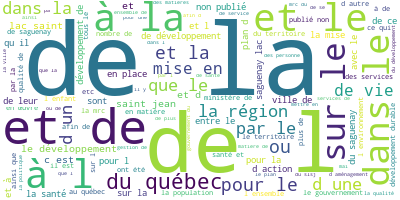

In [3]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df['text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

** **
#### Step 4: Prepare text for LDA analysis <a class="anchor\" id="data_preparation"></a>
** **

In [6]:
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words=set(stopwords.words("french"))
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = df.text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /home/amine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['plan', 'action', 'developpement', 'durable', 'ministere', 'sante', 'services', 'sociaux', 'edition', 'direction', 'communications', 'ministere', 'sante', 'services', 'sociaux', 'present', 'document', 'disponible', 'uniquement', 'version', 'electronique', 'adresse', 'wwwmsssgouvqcca', 'section', 'publications', 'genre', 'masculin', 'utilise', 'document', 'designe']


In [7]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 6), (4, 1), (5, 2), (6, 2), (7, 2), (8, 3), (9, 1), (10, 4), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 3), (19, 2), (20, 2), (21, 8), (22, 3), (23, 2), (24, 81), (25, 24), (26, 1), (27, 1), (28, 6), (29, 17)]


** **
#### Step 5: LDA model tranining <a class="anchor\" id="train_model"></a>
** **

In [8]:
from pprint import pprint

# number of topics
num_topics = 3

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"developpement" + 0.006*"quebec" + 0.005*"plus" + 0.004*"lac" + '
  '0.004*"saguenay" + 0.003*"services" + 0.003*"sante" + 0.003*"cette" + '
  '0.003*"vie" + 0.003*"region"'),
 (1,
  '0.006*"plus" + 0.006*"quebec" + 0.005*"lac" + 0.005*"developpement" + '
  '0.004*"non" + 0.004*"saguenay" + 0.004*"region" + 0.004*"saint" + '
  '0.004*"services" + 0.003*"ete"'),
 (2,
  '0.008*"quebec" + 0.007*"plus" + 0.006*"developpement" + 0.004*"lac" + '
  '0.004*"plan" + 0.003*"services" + 0.003*"region" + 0.003*"action" + '
  '0.003*"leurs" + 0.003*"enfants"')]


** **
#### Step 6: Analyzing our LDA model <a class="anchor\" id="results"></a>
** **

In [9]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os 
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('../../3LDA_cluster/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, '../../3LDA_cluster/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

/home/amine/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.002324  0.003268       1        1  38.830758
1     -0.004496  0.000075       2        1  31.582239
0      0.002172 -0.003343       3        1  29.587003, topic_info=               Term         Freq        Total Category  logprob  loglift
4240         publie   997.000000   997.000000  Default  30.0000  30.0000
815             non  1922.000000  1922.000000  Default  29.0000  29.0000
1511       saguenay  2428.000000  2428.000000  Default  28.0000  28.0000
338   developpement  4099.000000  4099.000000  Default  27.0000  27.0000
1128          sante  1930.000000  1930.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
525           faire   428.136933  1450.630854   Topic3  -6.2002  -0.0025
130          autres   455.734253  1701.010452   Topic3  -6.1377  -0.0992
209           comme   414.005287  1378.800861   Topic3  -6.2337   0.0147
707           leurs   424.582516  1615.367486   Topic3  -6.2085  -0.1184
497            etre   424.587232  1747.078166   Topic3  -6.2085  -0.1967

[293 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
4951       1  0.350159  acceptables
4951       2  0.562275  acceptables
4951       3  0.087540  acceptables
24         1  0.449324       action
24         2  0.261173       action
...      ...       ...          ...
4903       2  0.260842         vont
4903       3  0.411855         vont
31659      1  0.358227     xevaluer
31659      2  0.358227     xevaluer
31659      3  0.358227     xevaluer

[622 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
